In [1]:
# run XGBoost with early stopping
# use SHAP values to calculate feature importances

import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost
from scipy.stats import pearsonr
import pickle
import matplotlib
from matplotlib import pylab as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

param_grid = {"learning_rate": [0.03],
              "objective":['reg:linear'], # change eval metric to rmse
              #"objective":['count:poisson'], # change the eval_metric to 'poisson-nloglik'
              #"reg_alpha": [0e0,0.1,0.3,1e0,3e0,10e0],
              #"reg_lambda": [0e0,0.1,0.03,1e0,3e0,10e0],
              "seed": [np.random.randint(1e6)],
              #"max_depth": [2,3,5,7],
              "n_jobs": [-1],
              "colsample_bytree": [0.9],
              "subsample": [0.66],
              "missing": [np.nan], 
              "n_estimators": [2000]}

def xgb_cv(X_tr,Y_tr,X_t,Y_t,X_h,Y_h,title,to_plot=True):

    # find best_params
    test_score = np.zeros(len(ParameterGrid(param_grid)))
    
    regressors = []
    for i in range(len(ParameterGrid(param_grid))):
        XGB = xgboost.XGBRegressor()
        # set XGB parameters
        g = ParameterGrid(param_grid)[i]
        XGB.set_params(**g)
        # do early stopping
        XGB.fit(X_tr,Y_tr,early_stopping_rounds=50, eval_metric='rmse', \
                eval_set=[(X_t, Y_t)], verbose=False)
        # collect test scores
        test_score[i] = XGB.best_score
        regressors.append(XGB)

    # choose best parameters on scores
    indx_para = np.where(test_score == np.min(test_score))[0]
    best_params = np.array(ParameterGrid(param_grid))[indx_para[0]]
    
    Y_pred = XGB.predict(X_h,ntree_limit=XGB.best_ntree_limit)
    X_shap = XGB.get_booster().predict(xgboost.DMatrix(X_h),pred_contribs=True,ntree_limit=XGB.best_ntree_limit)#[:,:-1]
    
    if to_plot:
        print '   nr trees: ',XGB.best_ntree_limit
        print '   RMSE: ',np.sqrt(mean_squared_error(Y_h, Y_pred))
        print '   mean averaged error: ',np.mean(np.abs(Y_h-Y_pred))
        print '   R2 score: ',r2_score(Y_h, Y_pred)
        
        plt.figure(figsize=(6.4*2e0,4.8))
        plt.subplot(121)
        plt.plot(Y_h,Y_pred,'o')
        plt.plot(range(100),range(100))
        plt.xlim([-1,np.max(Y_h)])
        plt.ylim([-1,np.max(Y_h)])
        plt.xlabel('true values')
        plt.ylabel('predicted values')
        plt.title(title)
        
        plt.subplot(122)
        plt.plot(Y_pred,(Y_h-Y_pred),'o')
        plt.plot(range(100),np.zeros(100))
        plt.xlim([-1,np.max(Y_h)])
        plt.xlabel('predicted values')
        plt.ylabel('residuals (true - predicted)')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    return best_params,test_score[indx_para[0]],regressors[indx_para[0]],Y_pred,X_shap


/Users/azsom/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:55: RankWarning: Polyfit may be poorly conditioned


['Nr_Volunteers', 'tide', 'daily mean tide', 'daily min tide', 'daily max tide', 'daily stdev tide', 'total tourists, 1 day(s) ago', 'domestic tourists, 1 day(s) ago', 'international tourists, 1 day(s) ago', 'japanese tourists, 1 day(s) ago', 'other tourists,1 day(s) ago', 'total tourists, 2 day(s) ago', 'domestic tourists, 2 day(s) ago', 'international tourists, 2 day(s) ago', 'japanese tourists, 2 day(s) ago', 'other tourists,2 day(s) ago', 'total tourists, 3 day(s) ago', 'domestic tourists, 3 day(s) ago', 'international tourists, 3 day(s) ago', 'japanese tourists, 3 day(s) ago', 'other tourists,3 day(s) ago', 'total tourists, 4 day(s) ago', 'domestic tourists, 4 day(s) ago', 'international tourists, 4 day(s) ago', 'japanese tourists, 4 day(s) ago', 'other tourists,4 day(s) ago', 'total tourists, 5 day(s) ago', 'domestic tourists, 5 day(s) ago', 'international tourists, 5 day(s) ago', 'japanese tourists, 5 day(s) ago', 'other tourists,5 day(s) ago', 'total tourists, 6 day(s) ago', 'd

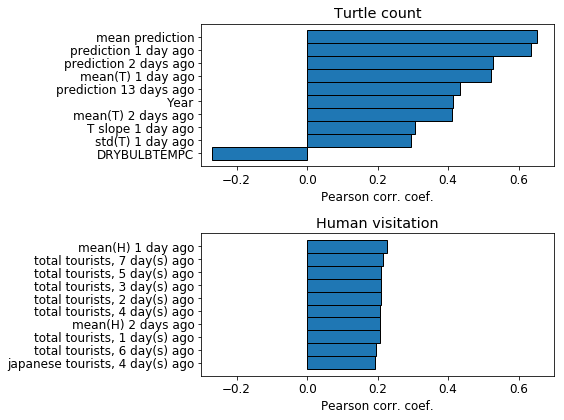

In [2]:
# prepare features and target variables
matplotlib.rcParams.update({'font.size': 12})

np.random.seed(0)

df = pd.read_csv('../data/combined_dataset.csv')

# target variables:
Y_T = df['TurtleNumber']
Y_P = df['PeopleNumber']

# Y_T = np.log10(df['TurtleNumber'])
# Y_T[df['TurtleNumber'] == 0] = -1
# Y_P = np.log10(df['PeopleNumber'])
# Y_P[df['PeopleNumber'] == 0] = -1

# datetime
datetime = df['DateTime']
# remove columns
df.drop(['TurtleNumber','PeopleNumber','DateTime'],axis=1,inplace=True)
# features
X = df
# add datetime related features
X['Year'] = pd.to_datetime(datetime).dt.year
X['Month'] = pd.to_datetime(datetime).dt.month
#X['Day'] = pd.to_datetime(datetime).dt.day
#X['Hour'] = pd.to_datetime(datetime).dt.hour
#X['Min'] = pd.to_datetime(datetime).dt.minute
X['Hour, float format'] = 1e0*(pd.to_datetime(datetime).dt.hour +  pd.to_datetime(datetime).dt.minute/60e0) / 24e0
X['Day, float format'] = 1e0*pd.to_datetime(datetime).dt.dayofyear / 365e0
X['Day, sin format'] = np.sin(1e0*pd.to_datetime(datetime).dt.dayofyear / 365e0*np.pi)
X['weekday'] = pd.to_datetime(datetime).dt.weekday
X['is weekend?'] = (pd.to_datetime(datetime).dt.weekday > 4).astype(int)

# add autocorrelation features
days = np.array([d[:10] for d in np.array(datetime)])
unique_days = np.array(sorted(np.unique(days)))
date_range = np.array([d[:10] for d in pd.date_range(days[0],days[-1]).astype(str)])

daily_mean_T = np.zeros(len(unique_days))
daily_std_T = np.zeros(len(unique_days))
daily_mean_P = np.zeros(len(unique_days))
daily_std_P = np.zeros(len(unique_days))
daily_slope_T = np.zeros(len(unique_days))
daily_intercept_T = np.zeros(len(unique_days))
daily_min_tide = np.zeros(len(unique_days))
daily_max_tide = np.zeros(len(unique_days))


for i in range(len(unique_days)):
    daily_mean_T[i] = np.mean(np.array(Y_T)[days == unique_days[i]])
    daily_std_T[i] = np.std(np.array(Y_T)[days == unique_days[i]])
    daily_mean_P[i] = np.mean(np.array(Y_P)[days == unique_days[i]])
    daily_std_P[i] = np.std(np.array(Y_P)[days == unique_days[i]])
    (slope,intercept) = np.polyfit(np.array(X['Hour, float format'])[days == unique_days[i]],np.array(Y_T)[days == unique_days[i]],deg=1)
    daily_slope_T[i] = slope
    daily_intercept_T[i] = intercept
    daily_min_tide[i] = np.unique(np.array(X['daily min tide'])[days == unique_days[i]])[0]
    daily_max_tide[i] = np.unique(np.array(X['daily max tide'])[days == unique_days[i]])[0]

f_mean_1 = np.zeros(len(days))*np.nan
f_mean_2 = np.zeros(len(days))*np.nan
f_std_1 = np.zeros(len(days))*np.nan
f_std_2 = np.zeros(len(days))*np.nan
f_slope_1 = np.zeros(len(days))*np.nan
f_slope_2 = np.zeros(len(days))*np.nan
f_slope_13 = np.zeros(len(days))*np.nan
f_intercept_1 = np.zeros(len(days))*np.nan
f_intercept_2 = np.zeros(len(days))*np.nan
f_intercept_13 = np.zeros(len(days))*np.nan
f_tide_2 = np.zeros(len(days))*np.nan
f_tide_3 = np.zeros(len(days))*np.nan
f_tide_4 = np.zeros(len(days))*np.nan
f_tide_5 = np.zeros(len(days))*np.nan

for i in range(len(days)):
    indx = np.where(unique_days == days[i])[0][0]
    if unique_days[indx-1] in date_range:
        f_mean_1[i] = daily_mean_T[indx-1]
        f_std_1[i] = daily_std_T[indx-1]
        f_slope_1[i] = daily_slope_T[indx-1]
        f_intercept_1[i] = daily_intercept_T[indx-1]
    if unique_days[indx-2] in date_range:
        f_mean_2[i] = daily_mean_T[indx-2]
        f_std_2[i] = daily_std_T[indx-2]
        f_slope_2[i] = daily_slope_T[indx-2]
        f_intercept_2[i] = daily_intercept_T[indx-2]
        f_tide_2[i] = daily_max_tide[indx-2] - daily_min_tide[indx-2]
    if unique_days[indx-3] in date_range:
        f_tide_3[i] = daily_max_tide[indx-3] - daily_min_tide[indx-3]
    if unique_days[indx-4] in date_range:
        f_tide_4[i] = daily_max_tide[indx-4] - daily_min_tide[indx-4]
    if unique_days[indx-5] in date_range:
        f_tide_5[i] = daily_max_tide[indx-5] - daily_min_tide[indx-5]
    if unique_days[indx-13] in date_range:
        f_slope_13[i] = daily_slope_T[indx-13]
        f_intercept_13[i] = daily_intercept_T[indx-13]
    else:
        f_slope_13[i] = np.nan
        f_intercept_13[i] = np.nan
        
X['mean(T) 1 day ago'] = f_mean_1
X['mean(T) 2 days ago'] = f_mean_2
X['std(T) 1 day ago'] = f_std_1
X['std(T) 2 days ago'] = f_std_2
X['T slope 1 day ago'] = f_slope_1
X['T slope 2 days ago'] = f_slope_2
X['T slope 13 days ago'] = f_slope_13
X['T intercept 1 day ago'] = f_intercept_1
X['T intercept 2 days ago'] = f_intercept_2
X['T intercept 13 days ago'] = f_intercept_13
X['prediction 1 day ago'] = X['Hour, float format']*X['T slope 1 day ago'] + X['T intercept 1 day ago']
X['prediction 2 days ago'] = X['Hour, float format']*X['T slope 2 days ago'] + X['T intercept 2 days ago']
X['prediction 13 days ago'] = X['Hour, float format']*X['T slope 13 days ago'] + X['T intercept 13 days ago']
X['mean prediction'] = np.mean([X['prediction 1 day ago'],X['prediction 2 days ago'],X['prediction 13 days ago']],axis=0)
X['tide amplitude 2 days ago'] = f_tide_2
X['tide amplitude 3 days ago'] = f_tide_3
X['tide amplitude 4 days ago'] = f_tide_4
X['tide amplitude 5 days ago'] = f_tide_5

f_mean_1 = np.zeros(len(days))
f_mean_2 = np.zeros(len(days))
f_std_1 = np.zeros(len(days))
f_std_2 = np.zeros(len(days))

for i in range(len(days)):
    indx = np.where(unique_days == days[i])[0][0]
    if unique_days[indx-1] in date_range:
        f_mean_1[i] = daily_mean_P[indx-1]
        f_std_1[i] = daily_std_P[indx-1]
    else:
        f_mean_1[i] = np.nan
        f_std_1[i] = np.nan
    if unique_days[indx-2] in date_range:
        f_mean_2[i] = daily_mean_P[indx-2]
        f_std_2[i] = daily_std_P[indx-2]
    else:
        f_mean_2[i] = np.nan
        f_std_2[i] = np.nan
        
X['mean(H) 1 day ago'] = f_mean_1
X['mean(H) 2 days ago'] = f_mean_2
X['std(H) 1 day ago'] = f_std_1
X['std(H) 2 days ago'] = f_std_2


# # feature combination
# columns = list(X_T.columns)
# columns = columns[:-24] + columns[-15:]
# print columns
# for c in range(len(columns)):
#     for cc in range(c+1):
#         X_T[columns[c]+' * '+columns[cc]] = X_T[columns[c]]*X_T[columns[cc]]

# columns = list(X_P.columns)
# columns = columns[:-24] + columns[-15:]
# print columns
# for c in range(len(columns)):
#     for cc in range(c+1):
#         X_P[columns[c]+' * '+columns[cc]] = X_P[columns[c]]*X_P[columns[cc]]

print list(X.columns)
print np.min(datetime),np.max(datetime)
print np.shape(X)

print np.shape(np.corrcoef(X.T))
feature_names = np.array(list(X.columns))

corr_T = np.zeros(len(feature_names))
corr_P = np.zeros(len(feature_names))
for i in range(len(feature_names)):
    corr_T[i] = X[feature_names[i]].corr(Y_T)
    corr_P[i] = X[feature_names[i]].corr(Y_P)
    

plt.figure(figsize=(8,6))
plt.subplot(211)
sorted_indcs = np.argsort(np.abs(corr_T))
for i in range(len(feature_names)):
    print feature_names[sorted_indcs[i]],corr_T[sorted_indcs[i]]

plt.barh(np.arange(10),corr_T[sorted_indcs[-10:]],np.zeros(10)+1,edgecolor='k')
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('Pearson corr. coef.')
plt.xlim([-0.3,0.7])
plt.title('Turtle count')
plt.subplot(212)
sorted_indcs = np.argsort(np.abs(corr_P))
plt.barh(np.arange(10),corr_P[sorted_indcs[-10:]],np.zeros(10)+1,edgecolor='k')
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('Pearson corr. coef.')
plt.xlim([-0.3,0.7])
plt.title('Human visitation')
plt.tight_layout()
plt.savefig('../results/corr_coef.png',dpi=150)

plt.show()

# plt.figure(figsize=(6.4*2.5e0,6.4*2.5e0))
# plt.pcolor(X.corr(),vmin=-1,vmax=1,cmap='seismic')
# plt.axes().set_aspect('equal')
# plt.xticks(np.arange(len(feature_names))+0.5,feature_names,rotation=90)
# plt.yticks(np.arange(len(feature_names))+0.5,feature_names)
# plt.colorbar()
# plt.tight_layout()
# plt.show()



978
[ 22  45  91 182 365 730]
*********
22
*********
2016-05-14 21.515953064 9.0
2015-12-20 28.2704601288 37.0
2016-03-13 8.67939662933 23.0
2014-11-02 18.5168218613 22.0
2016-10-24 44.6609764099 29.0
2016-08-11 15.764875412 10.0
2016-06-09 8.16401100159 22.0
2015-04-29 11.5894899368 24.0
2014-04-02 6.04865169525 5.0
2016-06-27 48.6090240479 30.0
2015-01-28 10.3660783768 30.0
2016-07-29 29.5196609497 58.0
2016-09-22 12.8001651764 32.0
2016-02-08 13.2589292526 2.0
2014-06-02 1.36919623613 2.5
2015-09-06 6.17468357086 9.0
2016-02-09 8.74153614044 3.0
2015-06-11 3.4327955246 22.0
2015-03-11 14.0832509995 9.0
2016-06-04 10.3912863731 1.0
2015-09-21 7.56628131866 18.0
2015-12-10 13.1927547455 7.0
2014-06-19 2.70758330822 1.0
2014-10-15 7.72711467743 15.0
2016-02-09 8.74153614044 3.0
2016-11-08 17.8643684387 2.0
2016-05-07 25.4383029938 29.0
2015-11-22 22.0741729736 20.0
2016-11-04 22.7358484268 4.0
2014-06-04 2.05094945431 2.5
2016-08-26 29.1229114532 14.0
2017-01-16 24.9950370789 43.5
2014

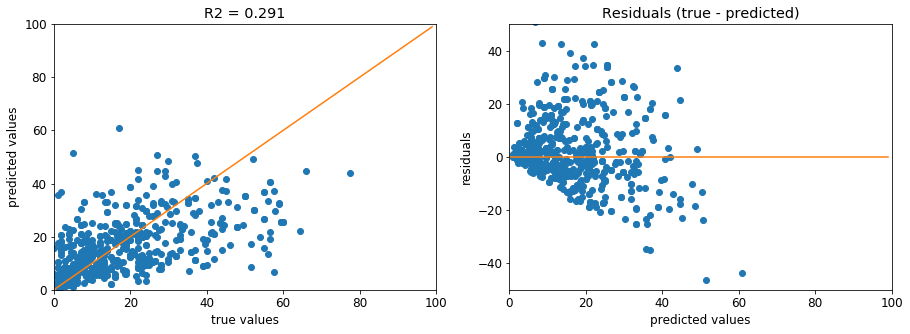

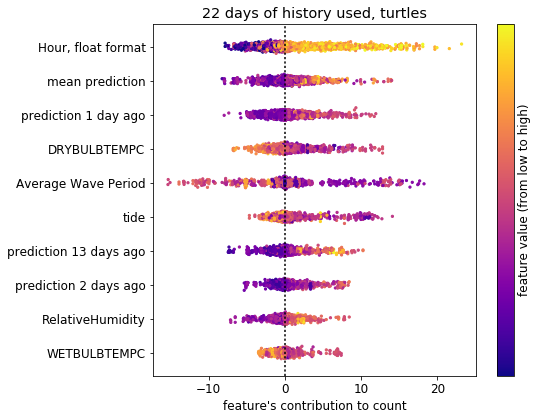

*********
45
*********
2016-11-04 38.0924015045 4.0
2016-02-29 13.651881218 6.5
2015-04-03 14.4856843948 10.0
2015-02-12 19.1771411896 12.0
2016-03-07 23.8483352661 26.5
2017-01-11 43.2408905029 69.0
2016-05-20 20.209028244 27.0
2016-12-17 11.8752002716 6.0
2015-09-17 10.6019945145 12.0
2014-12-10 11.1796245575 2.0
2014-09-08 12.0718784332 4.0
2017-01-29 21.6331157684 14.0
2014-10-10 10.339609623 1.0
2014-05-08 4.77640509605 2.0
2015-04-25 14.6753692627 4.0
2016-11-19 13.2048606873 28.0
2016-01-10 22.4777402878 22.5
2017-02-19 26.3882026672 54.0
2016-05-21 22.2063465118 22.0
2016-04-11 10.7241182327 25.0
2015-05-27 8.51858568192 11.5
2015-08-05 15.9935426712 28.0
2016-03-10 32.8420600891 18.0
2014-04-21 5.60467767715 6.0
2015-09-19 11.3846898079 3.0
2016-08-19 9.9128408432 14.0
2015-11-20 23.2185001373 21.0
2015-05-14 12.5510053635 7.0
2016-07-09 27.1977272034 56.0
2015-07-24 12.4100646973 13.0
2014-10-11 6.2023639679 6.0
2016-07-11 22.6500835419 20.0
2014-05-31 1.61672270298 2.0
2014-

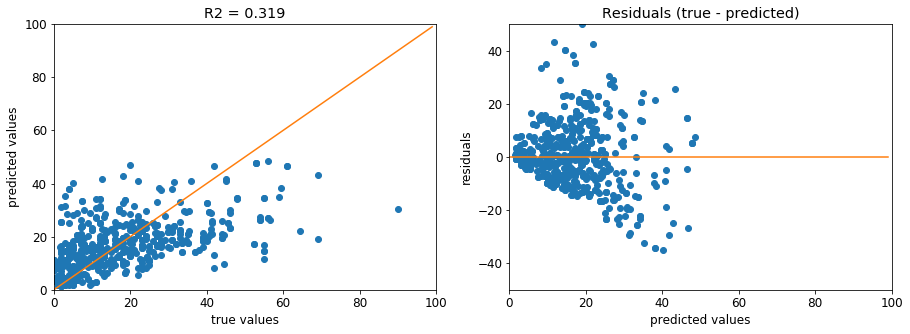

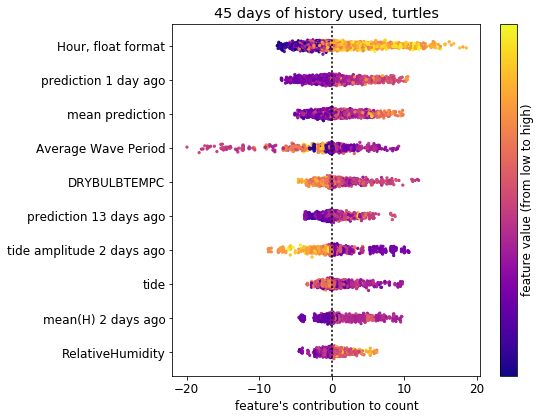

*********
91
*********
2014-08-20 11.0378937721 4.0
2015-10-22 15.3059334755 23.0
2015-03-09 14.7482948303 11.0
2015-07-08 9.95098590851 16.5
2017-01-20 24.9224319458 55.0
2014-10-02 10.1138181686 18.0
2015-05-28 16.0973014832 4.0
2015-08-03 9.63625526428 13.0
2015-10-03 15.5990924835 8.0
2014-08-05 2.63973355293 4.0
2015-02-07 19.0174531937 14.0
2014-11-15 24.1754417419 23.0
2016-01-13 15.1866049767 18.0
2016-03-15 23.426410675 25.5
2017-01-07 38.8428325653 61.0
2017-01-25 25.5168075562 2.0
2015-08-15 11.5220146179 4.0
2016-11-26 32.3598556519 36.0
2015-04-10 21.6077423096 18.0
2017-01-16 21.9381809235 43.5
2016-07-04 22.8384943008 20.5
2016-08-26 24.8962650299 14.0
2015-01-19 18.7774620056 12.0
2017-01-13 30.5067825317 20.5
2014-10-31 20.2328157425 20.5
2016-05-15 26.6050357819 5.0
2015-07-15 8.10907936096 13.0
2017-01-04 29.8595180511 22.0
2016-06-23 12.677189827 55.0
2016-08-11 25.6971282959 10.0
2016-07-04 22.8384943008 20.5
2016-11-23 30.6923904419 48.0
2015-01-14 15.2911996841 2

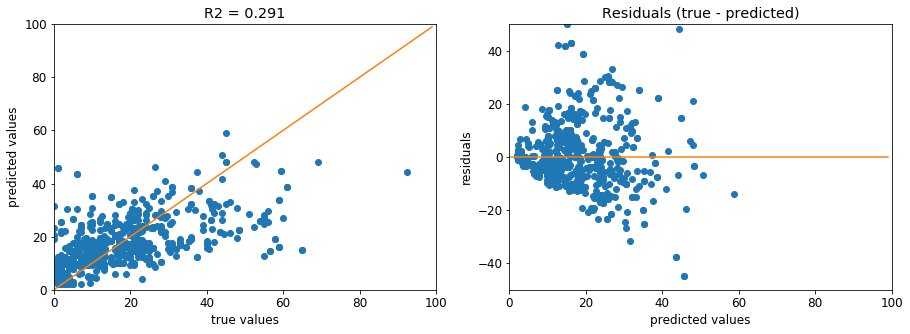

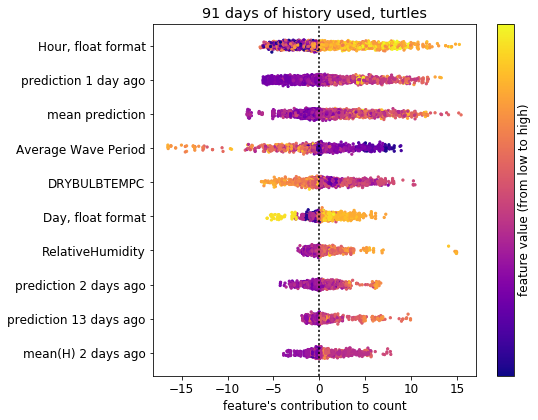

*********
182
*********
2016-08-21 25.5321655273 6.0
2016-03-17 23.3013477325 7.0
2015-01-06 11.8092937469 20.0
2015-05-28 17.1574668884 4.0
2015-04-26 9.61542224884 3.0
2016-10-19 11.0666475296 32.0
2017-02-10 27.4135818481 5.0
2017-01-15 20.3409786224 24.5
2016-12-28 32.6551876068 45.0
2016-06-18 18.4649658203 4.0
2016-06-03 19.2588691711 8.0
2016-10-10 20.2607688904 35.0
2016-06-25 30.9470863342 12.0
2015-07-20 11.63560009 8.0
2016-01-26 17.8589801788 0.0
2015-06-23 16.1575241089 18.0
2015-08-03 10.4620170593 13.0
2016-12-25 29.0483818054 18.0
2015-07-08 10.540099144 16.5
2016-11-18 26.079454422 15.0
2016-10-01 24.9196481705 44.0
2015-07-22 15.1662139893 10.0
2017-01-07 38.0237121582 61.0
2016-05-04 29.4267578125 34.0
2016-10-31 31.9535131454 32.0
2015-11-27 27.5940685272 32.0
2014-11-01 13.5851678848 23.0
2016-12-25 29.0483818054 18.0
2016-07-02 24.1697282791 57.5
2015-07-12 10.4582500458 9.0
2016-05-02 30.6112518311 28.0
2015-06-24 16.6117305756 18.0
2016-07-06 21.4847393036 4.0
2

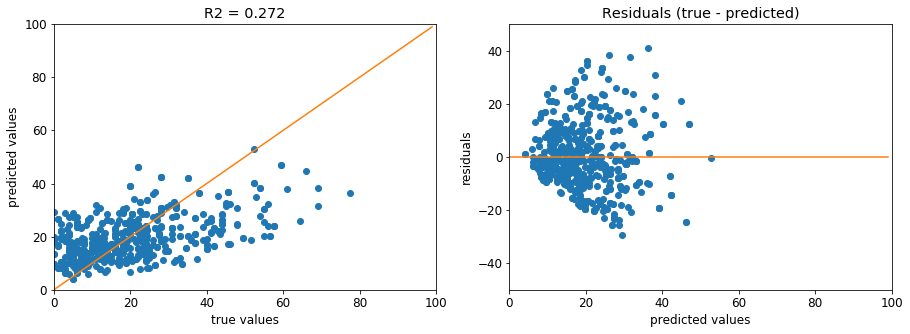

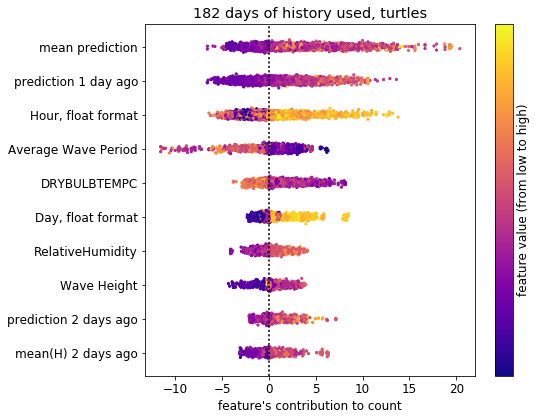

*********
365
*********
2015-08-19 13.2868447304 3.0
2016-05-26 10.1415171623 2.0
2015-10-01 13.1709022522 13.0
2016-03-28 13.6830224991 7.0
2015-07-25 12.756316185 3.0
2016-09-01 30.0607261658 48.5
2016-06-04 9.01000499725 1.0
2015-04-24 5.72379636765 5.0
2015-11-26 21.4265680313 16.5
2015-09-30 17.416765213 15.5
2016-02-02 14.5093717575 2.0
2015-09-04 11.1161227226 7.5
2016-11-21 28.2814674377 31.5
2015-04-24 5.72379636765 5.0
2015-06-30 4.23550319672 7.0
2017-02-09 26.1095104218 48.0
2015-11-23 18.0608901978 24.0
2016-12-20 41.8008651733 56.0
2015-05-06 4.2324962616 4.0
2015-05-26 18.6513633728 15.0
2015-04-17 11.0525827408 9.0
2015-07-10 17.4060764313 13.0
2016-08-09 25.4880056381 5.0
2016-10-04 23.8535890579 13.5
2016-10-02 33.5854759216 28.0
2015-10-26 11.943488121 25.0
2017-01-09 35.2889938354 37.5
2016-10-27 32.594669342 45.0
2016-02-08 13.5901050568 2.0
2016-10-26 41.2355766296 52.0
2016-05-12 16.3018026352 26.0
2015-10-13 11.6423912048 8.0
2015-08-29 10.8739037514 16.5
2017-0

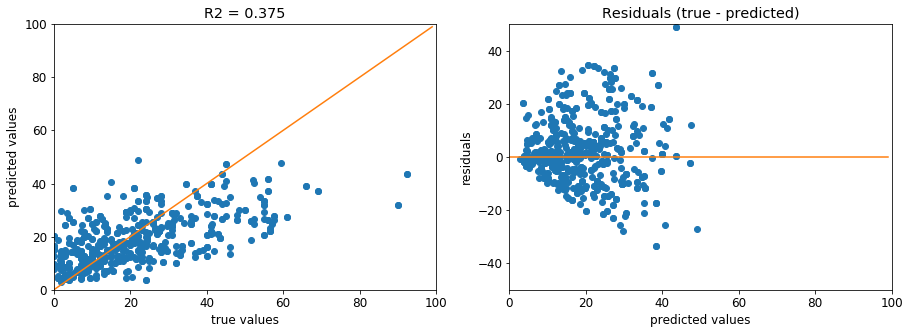

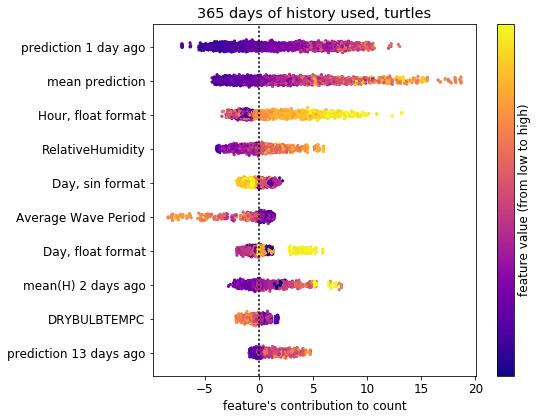

*********
730
*********
2016-06-20 12.9185461998 2.0
2017-01-22 32.9880447388 33.5
2016-11-15 17.5762996674 30.5
2016-09-28 49.2434539795 38.0
2016-07-01 12.6254210472 40.0
2016-07-25 16.6046791077 8.0
2016-08-28 18.6637649536 41.0
2016-09-30 24.3816394806 30.0
2016-07-18 15.3149404526 39.0
2017-01-22 32.9880447388 33.5
2017-01-04 21.7588453293 22.0
2017-01-17 35.186624527 43.0
2016-12-16 15.5125045776 0.0
2016-10-05 15.4120087624 33.0
2016-12-26 27.1085004807 50.0
2016-08-14 17.8847293854 11.0
2016-11-22 27.3205213547 58.0
2016-10-18 15.8878412247 13.0
2016-07-03 28.7562122345 24.0
2016-10-11 32.1938781738 51.0
2016-09-10 18.35871315 36.0
2016-07-31 21.4390649796 44.5
2016-08-24 11.3417143822 2.0
2017-02-13 25.02023983 7.5
2016-08-08 17.3920631409 2.0
2016-10-14 30.8565607071 40.5
2016-12-01 31.8097343445 20.0
2016-10-31 28.6559362411 32.0
2017-02-28 32.3491382599 18.0
2016-09-08 10.4515180588 36.0
2017-02-10 35.8021583557 5.0
2016-08-04 17.0056738853 29.5
2017-01-11 42.994720459 69.0

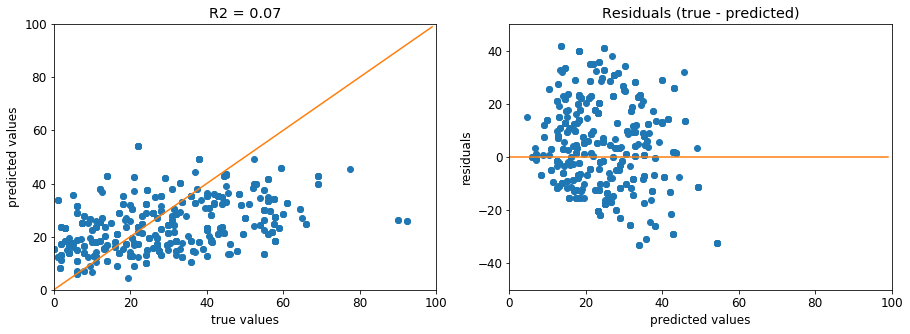

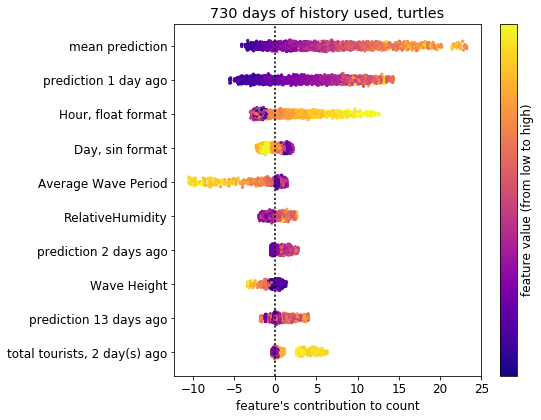

[ 0.30647527  0.29866422  0.30838768  0.17452468  0.33498946  0.06136306]


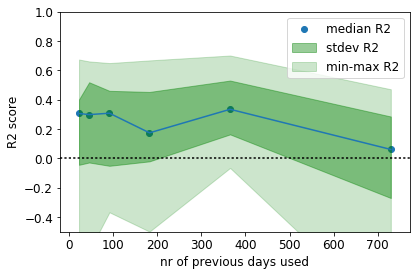

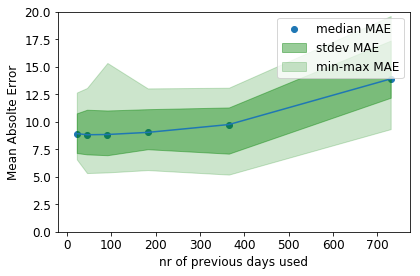

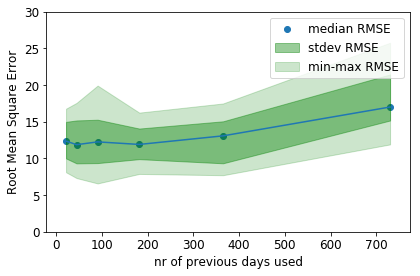

In [5]:
# CV pipeline mimicking future usage
np.random.seed(0)
# collect unique days
datetime = np.array(datetime)

days = np.array([d[:10] for d in datetime])
unique_days = sorted(np.unique(days))
print len(unique_days)

n_sim = 30
nr_days_holdout = 20
nr_models = 1
dt_days = np.array([365/16,365/8,365/4,365/2,365,365*2])
#dt_days = np.array([365])
R2_grid = np.zeros([len(dt_days),n_sim])
mae_grid = np.zeros([len(dt_days),n_sim])
rmse_grid = np.zeros([len(dt_days),n_sim])
print dt_days

# turtles or humans to predict? 
Y = Y_T

feature_names = np.array(list(X.columns))
for t in range(len(dt_days)):
    print '*********'
    print dt_days[t]
    print '*********'
    
    if Y.name == 'TurtleNumber':
        we_predict = 'turtles'
    else:
        we_predict = 'humans'
        
    # random days
    indices = np.random.choice(np.arange(dt_days[t],len(unique_days)),size=(n_sim,nr_days_holdout))
    
    X_shap_all = np.empty([0,np.shape(X)[1]+1])
    X_h_all = np.empty([0,np.shape(X)[1]])
    
    Y_pred_total = []
    Y_h_total = []
    holdout_days = []
    
    for n in range(n_sim):
        Y_all = []
        Y_pred_all = []   
        
        
        for i in range(nr_days_holdout):
            indx = int(indices[n,i])
            holdout_day = unique_days[indx]
            holdout_days.append(holdout_day)
            start_day = unique_days[indx - int(dt_days[t])]
            split_day = unique_days[indx - int(dt_days[t]*0.3)]

            # keep one day only in holdout
            Y_holdout = Y[days == holdout_day]
            X_holdout = X[days == holdout_day]

            # split data using split_day
            mask = (days < split_day)&(days >= start_day)
            X_train = X[mask]
            Y_train = Y[mask]
            mask = (days < holdout_day)&(days >= split_day)
            X_test = X[mask]
            Y_test = Y[mask]
            
            Y_pred = np.zeros(len(Y_holdout))
            X_shap = np.zeros([np.shape(X_holdout)[0],np.shape(X_holdout)[1]+1])
            for m in range(nr_models):
                best_params,best_score,XGB, Y_p, X_s = xgb_cv(X_train,Y_train,X_test,Y_test,X_holdout,Y_holdout,'turtles',to_plot=False)
                Y_pred += Y_p
                X_shap += X_s
            Y_pred = 1e0*Y_pred / nr_models
            X_shap = 1e0*X_shap / nr_models
            
            # compare daily mean counts
            Y_pred_all.append(np.median(Y_pred))
            Y_all.append(np.median(Y_holdout))
            X_shap_all = np.concatenate((X_shap_all,X_shap),axis=0)
            X_h_all = np.concatenate((X_h_all,X_holdout),axis=0)
            
            print holdout_day,np.median(Y_pred),np.median(Y_holdout)
            
        #Y_pred = np.array([item for sublist in Y_pred_all for item in sublist])
        Y_pred = np.array(Y_pred_all)
        Y_pred_total.append(Y_pred)
        
        #Y_holdout = np.array([item for sublist in Y_all for item in sublist])
        Y_holdout = np.array(Y_all)
        Y_h_total.append(Y_holdout)
        
        R2_grid[t,n] = r2_score(Y_holdout, Y_pred)
        mae_grid[t,n] = np.mean(np.abs(Y_holdout-Y_pred))
        rmse_grid[t,n] = np.sqrt(mean_squared_error(Y_holdout, Y_pred))
                
    # show on example plot per dt_days[t]
    
    print '   RMSE: ',np.median(rmse_grid[t])
    print '   mean abs error: ',np.median(mae_grid[t])
    print '   R2 score: ',np.median(R2_grid[t])
    
    
    Y_pred = np.array([item for sublist in Y_pred_total for item in sublist])        
    Y_holdout = np.array([item for sublist in Y_h_total for item in sublist])
    

    df_save = pd.DataFrame()
    df_save['holdout days'] = holdout_days
    df_save['predicted counts'] = Y_pred
    df_save['true counts'] = Y_holdout
    df_save.to_csv('../results/predictions.csv',index=False)
    
    plt.figure(figsize=(6.4*2e0,4.8))
    plt.subplot(121)
    plt.plot(Y_holdout,Y_pred,'o')
    if we_predict == 'humans':
        plt.xlim([0,50])
        plt.ylim([0,50])
    else:
        plt.xlim([0,100])
        plt.ylim([0,100])
    plt.plot(range(100),range(100))
    plt.xlabel('true values')
    plt.ylabel('predicted values')
    plt.title('R2 = '+str(np.around(r2_score(Y_holdout, Y_pred),3)))

    plt.subplot(122)
    plt.plot(Y_pred,Y_holdout-Y_pred,'o')
    plt.plot(range(100),np.zeros(100))
    if we_predict == 'humans':
        plt.xlim([0,50])
        plt.ylim([-25,25])
    else:
        plt.xlim([0,100])
        plt.ylim([-50,50])
    plt.xlabel('predicted values')
    plt.ylabel('residuals')
    plt.title('Residuals (true - predicted)')
    plt.tight_layout()
    plt.savefig('../results/Yt_Yp_'+we_predict+'_day'+str(dt_days[t])+'_nrmodels'+str(nr_models)+'.png',dpi=150)

    plt.show()
    
    # prepare feature importance X_shap plot
    sorted_indcs = np.argsort(np.mean(np.abs(X_shap_all[:,:-1]),axis=0))[::-1]

    plt.figure(figsize=(8,6))
    for i in range(10):
        plt.scatter(X_shap_all[:,sorted_indcs[i]],np.zeros(np.shape(X_shap_all)[0])+\
                    (10-1-i)+np.random.normal(0e0,0.05,size=np.shape(X_shap_all)[0]),\
                    s=5,c=X_h_all[:,sorted_indcs[i]],cmap='plasma')
    plt.axvline(0e0,linestyle='dotted',color='k')
    plt.yticks(range(10)[::-1],feature_names[sorted_indcs[:10]])
    plt.xlabel("feature's contribution to count")
    plt.colorbar(ticks=[],label='feature value (from low to high)')
    plt.legend(loc=4)
    plt.title(str(dt_days[t])+' days of history used, '+we_predict)
    plt.tight_layout()
    plt.savefig('../results/feature_imps_'+we_predict+'_day'+str(dt_days[t])+'_nrmodels'+str(nr_models)+'.png',dpi=150)
    plt.show()
    plt.close()


print np.median(R2_grid,axis=1)
plt.plot(dt_days,np.median(R2_grid,axis=1))
plt.scatter(dt_days,np.median(R2_grid,axis=1),label='median R2')
plt.fill_between(dt_days,np.percentile(R2_grid,16,axis=1),\
                 np.percentile(R2_grid,84,axis=1),alpha=0.4,\
                 label='stdev R2',color='g')
plt.fill_between(dt_days,np.percentile(R2_grid,0,axis=1),\
                 np.percentile(R2_grid,100,axis=1),alpha=0.2,\
                 label='min-max R2',color='g')
plt.axhline(0,color='k',linestyle=':')
plt.ylabel('R2 score')
plt.xlabel('nr of previous days used')
plt.legend()
plt.ylim([-0.5,1])
plt.tight_layout()
plt.savefig('../results/'+we_predict+'_R2_'+param_grid['objective'][0][:3]+'_'+str(n_sim)+'_'+str(nr_days_holdout)+'_'+str(nr_models)+'.png',dpi=150)
plt.show()


plt.plot(dt_days,np.median(mae_grid,axis=1))
plt.scatter(dt_days,np.median(mae_grid,axis=1),label='median MAE')
plt.fill_between(dt_days,np.percentile(mae_grid,16,axis=1),\
                 np.percentile(mae_grid,84,axis=1),alpha=0.4,\
                 label='stdev MAE',color='g')
plt.fill_between(dt_days,np.percentile(mae_grid,0,axis=1),\
                 np.percentile(mae_grid,100,axis=1),alpha=0.2,\
                 label='min-max MAE',color='g')
plt.ylabel('Mean Absolte Error')
plt.xlabel('nr of previous days used')
plt.ylim([0,20])
plt.legend()
plt.tight_layout()
plt.savefig('../results/'+we_predict+'_MAE_'+param_grid['objective'][0][:3]+'_'+str(n_sim)+'_'+str(nr_days_holdout)+'_'+str(nr_models)+'.png',dpi=150)
plt.show()

plt.plot(dt_days,np.median(rmse_grid,axis=1))
plt.scatter(dt_days,np.median(rmse_grid,axis=1),label='median RMSE')
plt.fill_between(dt_days,np.percentile(rmse_grid,16,axis=1),\
                 np.percentile(rmse_grid,84,axis=1),alpha=0.4,\
                 label='stdev RMSE',color='g')
plt.fill_between(dt_days,np.percentile(rmse_grid,0,axis=1),\
                 np.percentile(rmse_grid,100,axis=1),alpha=0.2,\
                 label='min-max RMSE',color='g')
plt.ylabel('Root Mean Square Error')
plt.xlabel('nr of previous days used')
plt.ylim([0,30])
plt.legend()
plt.tight_layout()
plt.savefig('../results/'+we_predict+'_RMSE_'+param_grid['objective'][0][:3]+'_'+str(n_sim)+'_'+str(nr_days_holdout)+'_'+str(nr_models)+'.png',dpi=150)
plt.show()

In [4]:
# simple CV


# # split dataset randomly
# X_t, X_test, Y_T_t, Y_T_test, Y_P_t, Y_P_test = train_test_split(X,Y_T,Y_P,test_size=0.2) 
# X_train, X_holdout, Y_T_train, Y_T_holdout, Y_P_train, Y_P_holdout = train_test_split(X_t,Y_T_t,Y_P_t,test_size=0.25) 
# print np.shape(X)
# print np.shape(X_train)
# print np.shape(X_test)
# print np.shape(X_holdout)


# print 'SPLIT DATASET RANDOMLY'
# # predict turtles
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_T_train,X_test,Y_T_test,X_holdout,Y_T_holdout,'turtles')
# # predict humans
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_P_train,X_test,Y_P_test,X_holdout,Y_P_holdout,'humans')


# # holdout non-random, train-test random
# mask_holdout = (X['Year']==2017)|((X['Year']==2016) & ((X['Month']>8 )))
# X_holdout = X.loc[mask_holdout]
# Y_T_holdout = Y_T.loc[mask_holdout]
# Y_P_holdout = Y_P.loc[mask_holdout]
# X_train, X_test, Y_T_train, Y_T_test, Y_P_train, Y_P_test = train_test_split(X.loc[~mask_holdout],Y_T.loc[~mask_holdout],Y_P.loc[~mask_holdout],test_size=0.2) 
# print np.shape(X)
# print np.shape(X_train)
# print np.shape(X_test)
# print np.shape(X_holdout)
# print 'HOLDOUT NON-RANDOM, TRAIN-TEST RANDOM'
# # predict turtles
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_T_train,X_test,Y_T_test,X_holdout,Y_T_holdout,'turtles')
# # predict humans
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_P_train,X_test,Y_P_test,X_holdout,Y_P_holdout,'humans')


# # split the dataset based on time
# mask_test = (X['Year']==2016) & ((X['Month']<=8 )&(X['Month']>2))
# mask_holdout = (X['Year']==2017)|((X['Year']==2016) & ((X['Month']>8 )))
# X_T_train = X_T.loc[~(mask_test|mask_holdout)]
# X_P_train = X_P.loc[~(mask_test|mask_holdout)]
# Y_T_train = Y_T.loc[~(mask_test|mask_holdout)]
# Y_P_train = Y_P.loc[~(mask_test|mask_holdout)]
# X_T_test = X_T.loc[mask_test]
# X_P_test = X_P.loc[mask_test]
# Y_T_test = Y_T.loc[mask_test]
# Y_P_test = Y_P.loc[mask_test]
# X_T_holdout = X_T.loc[mask_holdout]
# X_P_holdout = X_P.loc[mask_holdout]
# Y_T_holdout = Y_T.loc[mask_holdout]
# Y_P_holdout = Y_P.loc[mask_holdout]
# print np.shape(X_T)
# print np.shape(X_P_train)
# print np.shape(X_T_test)
# print np.shape(X_P_holdout)

# print 'SPLIT BASED ON TIME'
# # predict turtles
# best_params,best_score,XGB,Y_pred,X_shap = xgb_cv(X_T_train,Y_T_train,X_T_test,Y_T_test,X_T_holdout,Y_T_holdout,'turtles')
# # predict humans
# best_params,best_score,XGB,Y_pred,X_shap = xgb_cv(X_P_train,Y_P_train,X_P_test,Y_P_test,X_P_holdout,Y_P_holdout,'humans')


